In [149]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time


In [150]:
np.random.seed(42)

In [151]:
data,target = load_breast_cancer(return_X_y=True,as_frame=False)
data = StandardScaler().fit_transform(data)

In [152]:
def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

In [153]:

def initialize(data, k):
    centroids = []
    centroids.append(data[np.random.randint(data.shape[0])]) # First centroid is random 

    for _ in range(k - 1):
        distances = []
        for point in data:
            min_dist = min([distance(point, c) for c in centroids]) # Distance to closest centroid
            distances.append(min_dist)
        
        next_centroid = data[np.argmax(distances)] # farthest point is the next centroid
        centroids.append(next_centroid)
    
    return np.array(centroids)


In [154]:
def random_initialization(data, k):
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    return centroids

In [155]:
def assign_to_clusters(data, centroids):
    clusters = []
    for point in data:
        distances = []
        for c in centroids:
            distances.append(distance(point, c))

        cluster = np.argmin(distances) # index of closest centroid
        clusters.append(cluster) # assign point to closest centroid
    return np.array(clusters) # array of cluster for every point

In [156]:
def update_centroids(data, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster_points = data[clusters == i] # get points assigned to cluster i
        new_centroid = np.mean(cluster_points, axis=0) # mean of points in cluster i
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

In [157]:
def calculate_inertia(data, centroids, clusters):
    inertia = 0
    for i, point in enumerate(data):
        centroid = centroids[clusters[i]] # centroid of assigned cluster
        inertia += np.linalg.norm(point - centroid)**2 # sum of squared norm of point to centroid
    return inertia

In [158]:
def kmeans(data, centroids, tolerance, max_iterations):
    inertia_history = []
    startTime = time.time()
    while(max_iterations > 0):
        clusters = assign_to_clusters(data, centroids)
        inertia = calculate_inertia(data, centroids, clusters)
        new_centroids = update_centroids(data, clusters, len(centroids))
        inertia_history.append(inertia) 
        diff=0
        for i in range(len(centroids)):
            diff += distance(centroids[i], new_centroids[i])
        centroids = new_centroids

        if diff < tolerance:
            break
        max_iterations -= 1
    endTime = time.time()
    convergenceTime = endTime - startTime
    return centroids, clusters, inertia_history, convergenceTime

In [159]:
def elbow_method(data, max_k, tolerance, max_iterations, initializationType=initialize):
    inertia_values = []
    for k in range(1, max_k + 1):

        best_inertia = float('inf')
        times=[]
        for _ in range(10):  # 10 runs for each k to fix increasing inertia issue
            centroids = initializationType(data, k)
            _, _, inertia_history, t = kmeans(data, centroids, tolerance, max_iterations)
            times.append(t)
            if inertia_history[-1] < best_inertia:
                best_inertia = inertia_history[-1]
        inertia_values.append(best_inertia)
        print(f'k={k}, Best Inertia={best_inertia}, Average Convergence Time={np.mean(times):.4f} seconds')
    print("Convergence iterations (speed): ", len(inertia_history))
    plt.plot(range(1, max_k + 1), inertia_values, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

k=1, Best Inertia=17069.999999999993, Average Convergence Time=0.0380 seconds
k=2, Best Inertia=11595.461473962347, Average Convergence Time=0.2988 seconds
k=3, Best Inertia=10061.797818243695, Average Convergence Time=0.4267 seconds
k=4, Best Inertia=9574.371583740492, Average Convergence Time=0.7338 seconds
k=5, Best Inertia=8898.604283828121, Average Convergence Time=0.5343 seconds
k=6, Best Inertia=8477.230050907636, Average Convergence Time=0.7471 seconds
k=7, Best Inertia=7849.212159929443, Average Convergence Time=0.9659 seconds
k=8, Best Inertia=7357.98283295799, Average Convergence Time=1.5223 seconds
k=9, Best Inertia=6979.745628456275, Average Convergence Time=1.3827 seconds
k=10, Best Inertia=6914.958836878349, Average Convergence Time=1.3950 seconds
Convergence iterations (speed):  24


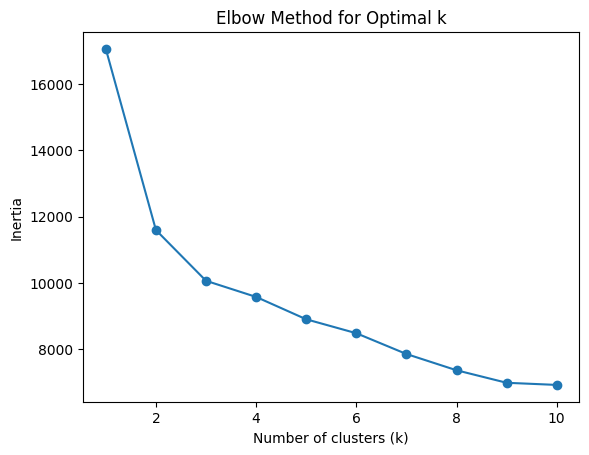

In [160]:
elbow_method(data, 10, tolerance=1e-4, max_iterations=100)

In [161]:
def calculate_silhouette_score(data, clusters, centroids):
    silhouette_scores = []
    for i, my_point in enumerate(data):
        cluster = clusters[i]
        same_cluster_points = data[clusters == cluster]
        if len(same_cluster_points) > 1:
            distances=[]
            for point in same_cluster_points:
                if not np.array_equal(my_point, point):
                    dist = distance(my_point, point)
                    distances.append(dist)
            a_i = np.mean(distances) # average distance to other points in the same cluster

        else:
            a_i = 0
        
        b_i = float('inf')
        for j, _ in enumerate(centroids):
            if j != cluster:
                other_cluster_points = data[clusters == j] # points in other clusters
                distances = []
                for point in other_cluster_points:
                    dist = distance(my_point, point)
                    distances.append(dist)
                avg_dist = np.mean(distances) # average distance to points in other cluster
                if avg_dist < b_i:
                    b_i = avg_dist 
        
        # calculate silhouette score for point i
        if max(a_i, b_i) > 0:
            s_i = (b_i - a_i) / max(a_i, b_i)
        else:
            s_i = 0
        silhouette_scores.append(s_i)
    
    return np.mean(silhouette_scores)

In [162]:
def silhouette_analysis(data, max_k, tolerance, max_iterations, inializationType=initialize):
    sil_scores = []
    for k in range(2, max_k + 1):
        centroids = inializationType(data, k)
        centroids, clusters, inertia_history, convergenceTime = kmeans(data, centroids, tolerance, max_iterations)
        sil_score = calculate_silhouette_score(data, clusters, centroids)
        sil_scores.append(sil_score)
    plt.plot(range(2, max_k + 1), sil_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.show()

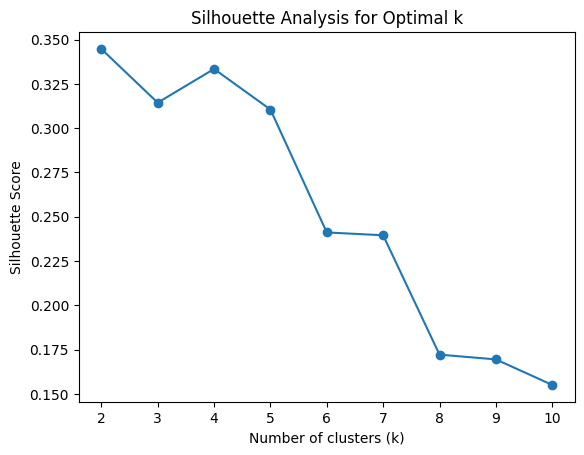

In [163]:
silhouette_analysis(data, 10, tolerance=1e-4, max_iterations=100)

In [164]:
def gap_statistics(data, max_k, b=10, tolerance=1e-4, max_iterations=100, initializationType=initialize):
    import numpy as np

    def generate_reference_data(x):
        return np.random.uniform(low=x.min(axis=0), high=x.max(axis=0), size=x.shape) # generate random reference data

    gap_values = []
    ref_inertias = []
    for k in range(1, max_k + 1):
        centroids = initializationType(data, k)
        centroids, clusters, _, _ = kmeans(data, centroids, tolerance, max_iterations)
        orig_inertia = calculate_inertia(data, centroids, clusters)
   
        for _ in range(b): # b reference datasets
            ref_data = generate_reference_data(data)
            ref_centroids = initializationType(ref_data, k)
            ref_centroids, ref_clusters, _, _ = kmeans(ref_data, ref_centroids, tolerance, max_iterations)
            ref_inertia = calculate_inertia(ref_data, ref_centroids, ref_clusters)
            ref_inertias.append(ref_inertia)

        gap_value = np.log(np.mean(ref_inertias)) - np.log(orig_inertia) # compare log inertias (log for scaling)
        gap_values.append(gap_value)
    plt.plot(range(1, max_k + 1), gap_values, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic Method for Optimal k')
    plt.show()

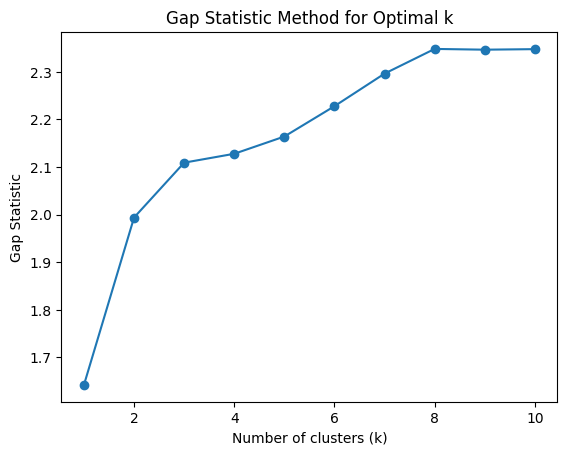

In [165]:
gap_statistics(data, 10, b=10, tolerance=1e-4, max_iterations=100)

k=1, Best Inertia=17069.999999999993, Average Convergence Time=0.0421 seconds
k=2, Best Inertia=11595.461473962347, Average Convergence Time=0.1952 seconds
k=3, Best Inertia=10061.797818243695, Average Convergence Time=0.5103 seconds
k=4, Best Inertia=9331.967113601004, Average Convergence Time=0.6000 seconds
k=5, Best Inertia=8558.18693522358, Average Convergence Time=1.0663 seconds
k=6, Best Inertia=7976.42771494189, Average Convergence Time=1.1682 seconds
k=7, Best Inertia=7539.990912413907, Average Convergence Time=1.2365 seconds
k=8, Best Inertia=7212.646925013721, Average Convergence Time=1.5638 seconds
k=9, Best Inertia=6858.484138981563, Average Convergence Time=1.5761 seconds
k=10, Best Inertia=6699.901276281237, Average Convergence Time=2.0156 seconds
Convergence iterations (speed):  32


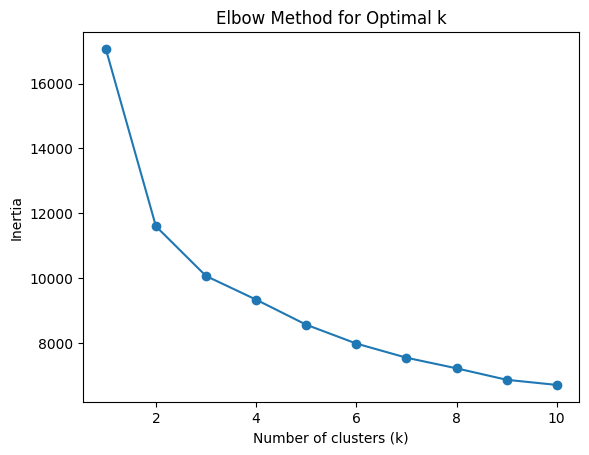

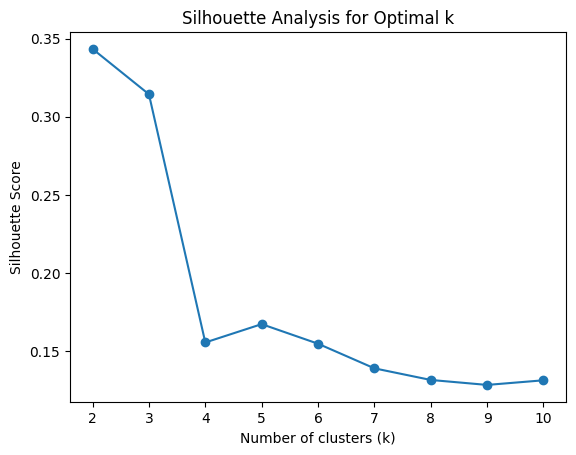

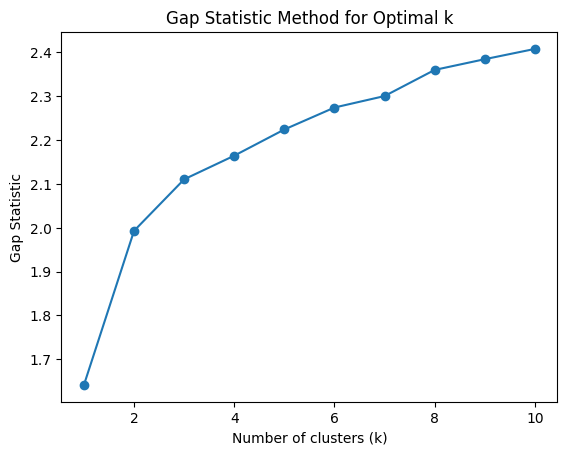

In [166]:
elbow_method(data, 10, tolerance=1e-4, max_iterations=100, initializationType=random_initialization)
silhouette_analysis(data, 10, tolerance=1e-4, max_iterations=100, inializationType=random_initialization)
gap_statistics(data, 10, b=10, tolerance=1e-4, max_iterations=100, initializationType=random_initialization)